# 06 Nonlinear classifiers - PART 1 - RANDOM FOREST
---
   
# Compared conditions

In order to answer the questions below, I created a function that, process the data automatically performs grid search for different parameters and make predictions for validation train and test data. In total, I evaluated 480 models with different:
- __tree number__ (1-200)
- __with balanced and unbalanced classes_
    * unbalanced classes were described as default on the plots
- __Extracted features prepaprocessed with PCA or not__, 
- __Models build using different number of principial axes (10, 30 or 250)__


# Answering two questions for nonlinear classifiers:
## Can you do better with random forest models than the baseline models from above (ie. logreg, decission trees, knn)  
Yes.   
An extensive comparison of random forest models created with different parameteres, and data preparation allowed to find the appraoch that allows classsified the images in swissroad dataset with 94.4% accuracy (validation dataset). Overall, the trees created with balanced class weights, larger number of estimators, larger number of features, and lartger max_depth were performing better then the rasndom forest models with smaller values in each of these categories. However, it was not the rule, as many top performing models were constructed using reduced number of features.
  
## Does increasing the number of trees help  
Overall yes,   
Models with larger number of trees had also larger accuracy, with maximum peak validation accuracy at 75-150 estimators. Adding more estimators, (eg 200 in total) was typically, reducing model accuracy. Importantly, the number of estimators, that allowed building the best performing model was lower for datasets with lower number of features, eg. for images classiffied using only 10 first principial axes, the optimal number of estimators was from 5 to 10 (see figures and the table below), and the model accuracy was lower then the accuracy of models constructed with larger number of features. 


# Config

In [1]:
# ************************************************************************* #
#     Author:   Pawel Rosikiewicz                                           #       
#     Copyrith: IT IS NOT ALLOWED TO COPY OR TO DISTRIBUTE                  #
#               these file without written                                  #
#               persmission of the Author                                   #
#     Contact:  prosikiewicz@gmail.com                                      #
#                                                                           #
# ************************************************************************* #

# Config

# basedir
basedir = '/Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution'

# project config
project_name = "Pawel_Rosikiewicz_EPFLext_Project4"
dataset_name = "swissroads"
subset_names = ["train", "valid", "test"]
module_names = ["imagenet"]
class_colors = {          "car": "orange",
                          "van": "steelblue",
                          "truck": "red",
                          "bike": "forestgreen",
                          "motorcycle" : "purple",
                           "other": "dimgrey"}

# task config
task_name = "random_forest" 
train_subset_names = ["train", "valid"] # data subsets, used together in part 1 and in part 3 for ploting image examples and PCA analyis
test_subset_names = ["test"]


# Note:
"""in some cases train, test and valid datasets, may be also subset names of the datasets, 
   this script works by loading selected daset subsets into either train and test category, 
   validation ataset is created automatically, at random fro 30% of train dataset.
   all saved predictions have reference to original images in raw data
""";

# Load packages

In [2]:
import os # allow changing, and navigating files and folders, 
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import pickle
import warnings
import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get some basif functions, heping with plot mnaking 
import matplotlib.pyplot as plt # for making plots, 

from PIL import Image, ImageDraw
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
import graphviz # allows visualizing decision trees,

# Load custom functions created for the project from basedir/src/utils

In [3]:
os.chdir(basedir)
sys.path.append(basedir)

# my tools, loaded only form basedir, 
from src.utils.data_loaders import load_encoded_imgbatch_using_logfile, load_raw_img_batch
from src.utils.example_plots_after_clustering import plot_img_examples, create_spaces_between_img_clusters, plot_img_examples_from_dendrogram
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.logreg_tools import my_logredCV, plot_examples_with_predictions_and_proba, plot_examples_with_predictions_and_proba_gamma
from src.utils.random_forest import random_forest_grid_search, plot_random_tree_summary_andor_table
from src.utils.model_summary_plots import plot_grid_acc_and_return_summary_df, visual_model_summary
from src.utils.SVM_tools import SVM_grid_search, plot_grid_acc_and_return_summary_df
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.model_summary_plots import plot_grid_acc_and_return_summary_df, visual_model_summary, model_gridsearch_summary_plots
from src.utils.knn_tools import knn_grid_search

# one of my functions was generating warnign, on copies, despite using proper syntax, 
warnings.filterwarnings("ignore")

# setup paths for the task

In [4]:
PATH_raw = os.path.join(basedir, "data/raw", dataset_name)
PATH_encoded = os.path.join(basedir, "data/interim", dataset_name)
PATH_results = os.path.join(basedir, "data/results", f"{dataset_name}_{task_name}")

# create new direcory for task results, 
try: 
    os.mkdir(PATH_results)
    try:
        os.chdir(PATH_results)
        print("PATH_results was created")
    except:
        print("ERROR: PATH_results was not created correctly")
except: 
    print("file already exist, or PATH_results was not created correctly")

PATH_results was created


# Run grid search to find best performin SVM model and collect results with each model
---
* The fucntion allows comparing all conditions that were described in section introduction, 
* the data are loaded using custom made genberastors, keras image generators,
* train and valid data are mixed and divided again in proportion 0.7:0.3,

In [6]:
# ...........................................................................................
# run grid search, 

# grid for parameter search, 
grid = ParameterGrid({
        'max_depth':[1,2,3,4,5,None],
        'n_estimators': [1,2,5,10,25,50,75,100,150,200],
        'class_weight': ['balanced', None],
        'pca':[0, 10, 30, 250]
    })


# ...........................................................................................
# grid search with cross-validation on parameters provided for logarithmic regression, 
for module_name in module_names:
    print(f"- {module_name} -")
    print(f"{len(grid)} parameter combinations will be evaluated", end=", ")
    print(f"if will take approximately {np.round(len(grid)*9/1000, 1)} min, started: {pd.to_datetime('now')}")
        
    
    # STEP 1. run grid search, 
    dt_results_list, dot_data_dict, model_predictions_dict = random_forest_grid_search(
        path=PATH_encoded, 
        dataset_name=dataset_name, 
        subset_names_tr=train_subset_names, 
        subset_names_te=test_subset_names, 
        module_names=[module_name], 
        class_encoding=dict(zip(list(class_colors.keys()), list(range(len(class_colors))))), 
        grid=grid, 
        param_names_for_DecisionTreeClassifier=['n_estimators', 'max_depth', 'class_weight'], 
        track_progres=True,
        verbose=False)

                
    # STEP 2. save files 
    os.chdir(PATH_results)

    # .. save summary table
    pd.DataFrame(dt_results_list).to_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv", header=True)
    
    # .. save dot_data_dict into a pickle file
    '''# to re-load use: with open(pickle_name, 'rb') as file:  data = pickle.load(file) # rb - read binary'''
    with open(f"{task_name}__{module_name}__{dataset_name}__dot_data_dict.p", 'wb') as file: # wb - write binary,
        pickle.dump(dot_data_dict, file)
        
    # .. save the model_predictions_dict into a pickle file
    with open(f"{task_name}__{module_name}__{dataset_name}__model_predictions_dict.p", 'wb') as file: # wb - write binary,
        pickle.dump(model_predictions_dict, file)     
    
    
print("\nDONE....")    


- imagenet -
480 parameter combinations will be evaluated, if will take approximately 4.3 min, started: 2020-11-11 13:34:27.098482
0 imagenet _________________________________________ 2020-11-11 13:34:27.098766
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
DONE _________________________________________ 2020-11-11 13:36:21.539598


DONE....


# Evaluate models created with grid search
---

### Show top ten best performing models
* classyfication is based on validation accuracy,  

In [8]:
# SHOW TABLE WITH 10 BEST PERFORMINGH MODELS, 
for i, module_name in enumerate(module_names):
    try:
        # reload the data
        os.chdir(PATH_results)
        one_module_summary_df = pd.read_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv")
        
        if i==0:
            summary_df = one_module_summary_df   
        else:
            summary_df = pd.concat([summary_df,one_module_summary_df], axis=0)
    except:
        pass
    
# sort summary table 
features_to_display = ["model_ID", "model_acc_valid", "model_acc_train", "baseline_acc_train",
                       "baseline_acc_valid", "pca_components_used", "max_depth", "class_weight","n_estimators"]
df_sorted = summary_df.sort_values("model_acc_valid", ascending=False).loc[:,features_to_display].head(10)
display(df_sorted.head(10))

model_ID  model_acc_valid  model_acc_train  baseline_acc_train  \
226       226         0.944444         1.000000            0.245734   
384       384         0.944444         0.979522            0.245734   
436       436         0.944444         1.000000            0.245734   
420       420         0.944444         1.000000            0.245734   
428       428         0.944444         1.000000            0.245734   
228       228         0.936508         1.000000            0.245734   
382       382         0.936508         0.969283            0.245734   
471       471         0.936508         1.000000            0.245734   
236       236         0.936508         1.000000            0.245734   
235       235         0.936508         1.000000            0.245734   

     baseline_acc_valid  pca_components_used  max_depth class_weight  \
226            0.190476                   30        NaN     balanced   
384            0.190476                    0        4.0          NaN   
436            0.190476                    0        5.0          NaN   
420            0.190476                    0        5.0          NaN   
428            0.190476                    0        5.0          NaN   
228            0.190476                    0        NaN     balanced   
382            0.190476                   30        4.0          NaN   
471            0.190476                  250        NaN          NaN   
236            0.190476                    0        NaN     balanced   
235            0.190476                  250        NaN     balanced   

     n_estimators  
226            75  
384            75  
436           200  
420            50  
428           100  
228           100  
382            50  
471           100  
236           200  
235           150

# Compare train and validation accuracy of models created using different combinations of parameters and data preparation approaches
---
* The Table below figures shows the best performing model from each plot, with relevant parameters

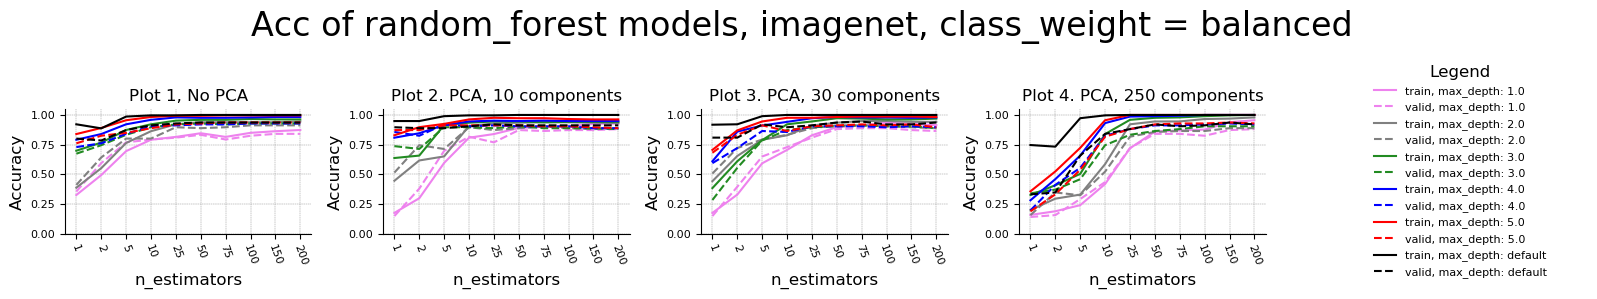

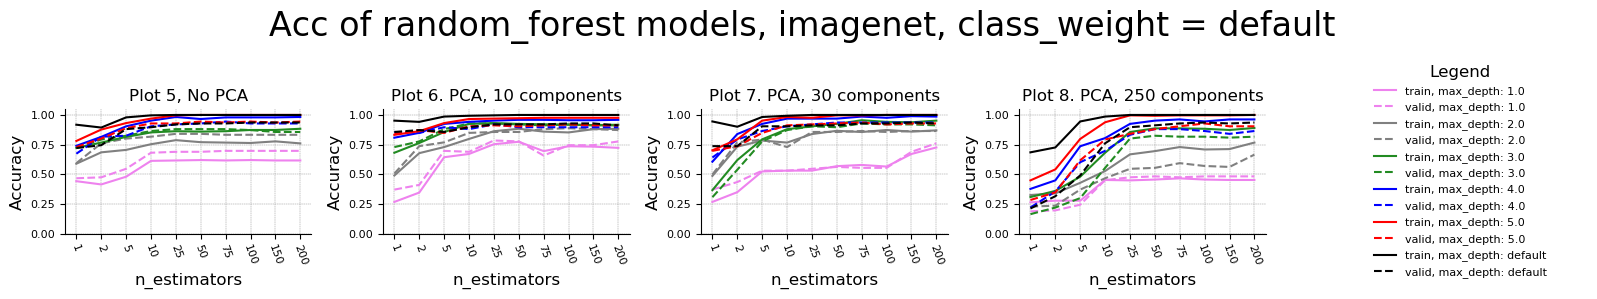

Plot_nr  model_ID         method    module  model_acc_train  \
2  Plot 3       226  random_forest  imagenet         1.000000   
4  Plot 5       384  random_forest  imagenet         0.979522   
0  Plot 1       184  random_forest  imagenet         0.996587   
3  Plot 4       195  random_forest  imagenet         1.000000   
6  Plot 7       382  random_forest  imagenet         0.969283   
7  Plot 8       471  random_forest  imagenet         1.000000   
5  Plot 6       333  random_forest  imagenet         0.924915   
1  Plot 2       129  random_forest  imagenet         0.914676   

   model_acc_valid  model_acc_test class_weight  pca_components_used  \
2         0.944444            0.90     balanced                   30   
4         0.944444            0.90          NaN                    0   
0         0.936508            0.92     balanced                    0   
3         0.936508            0.94     balanced                  250   
6         0.936508            0.90          NaN                   30   
7         0.936508            0.92          NaN                  250   
5         0.928571            0.92          NaN                   10   
1         0.920635            0.86     balanced                   10   

   n_estimators  max_depth  baseline_acc_train  baseline_acc_valid  \
2            75        NaN            0.245734            0.190476   
4            75        4.0            0.245734            0.190476   
0            75        5.0            0.245734            0.190476   
3           150        5.0            0.245734            0.190476   
6            50        4.0            0.245734            0.190476   
7           100        NaN            0.245734            0.190476   
5            10        3.0            0.245734            0.190476   
1             5        4.0            0.245734            0.190476   

   baseline_acc_test  
2               0.22  
4               0.22  
0               0.22  
3               0.22  
6               0.22  
7               0.22  
5               0.22  
1               0.22

In [9]:
# plot accuracy results for models created with different parameters
for module_name in module_names:
    
    try:
        
        # load summary table, 
        os.chdir(PATH_results)
        summary_df = pd.read_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv")

        # restore deafult settign for matplolib 
        mpl.rcdefaults() 

        # summary plots and table, 
        best_performing_model_on_each_plot = model_gridsearch_summary_plots(
                data=summary_df, 
                module_names=[module_name],
                fig_title_prefix = f"Acc of {task_name} models, {module_name}, class_weight =",
                create_figure = True,
                # ...
                fig_dname        = "class_weight",
                subplots_dname   = "pca_components_used",
                xaxis_dname      = "n_estimators",
                linecolor_dname  = "max_depth",
                linestyle_dnames = ["train", "valid"],
                # ...
                figsize=(16,3),
                fontscale=0.8,
                x_label = None,
                y_label = "Accuracy",
                y_limits = (0,1.05),
                subplots_adjust_top=0.65
            )
    
        
        # display summary table with best poerforming models, 
        display(best_performing_model_on_each_plot.sort_values("model_acc_valid", ascending=False))
  
    except:
        pass

# Show Predictions made with the best performing model for test data
---

* The best model was selected using validation accuracy, from all compared models in that section, 
* border colors arround each picture show true class of that image (see legend, for class-color pairs),
* the groups of images (labelled on top of each group), show classyfication made by the model,
* the probability values displayed on each image were calculated using model.predict_proba() function, 
* Predictions in each group were summarized, on pie plots below the main figure, 
* you may double click on the image to make it larger, 

Found 50 images belonging to 6 classes.


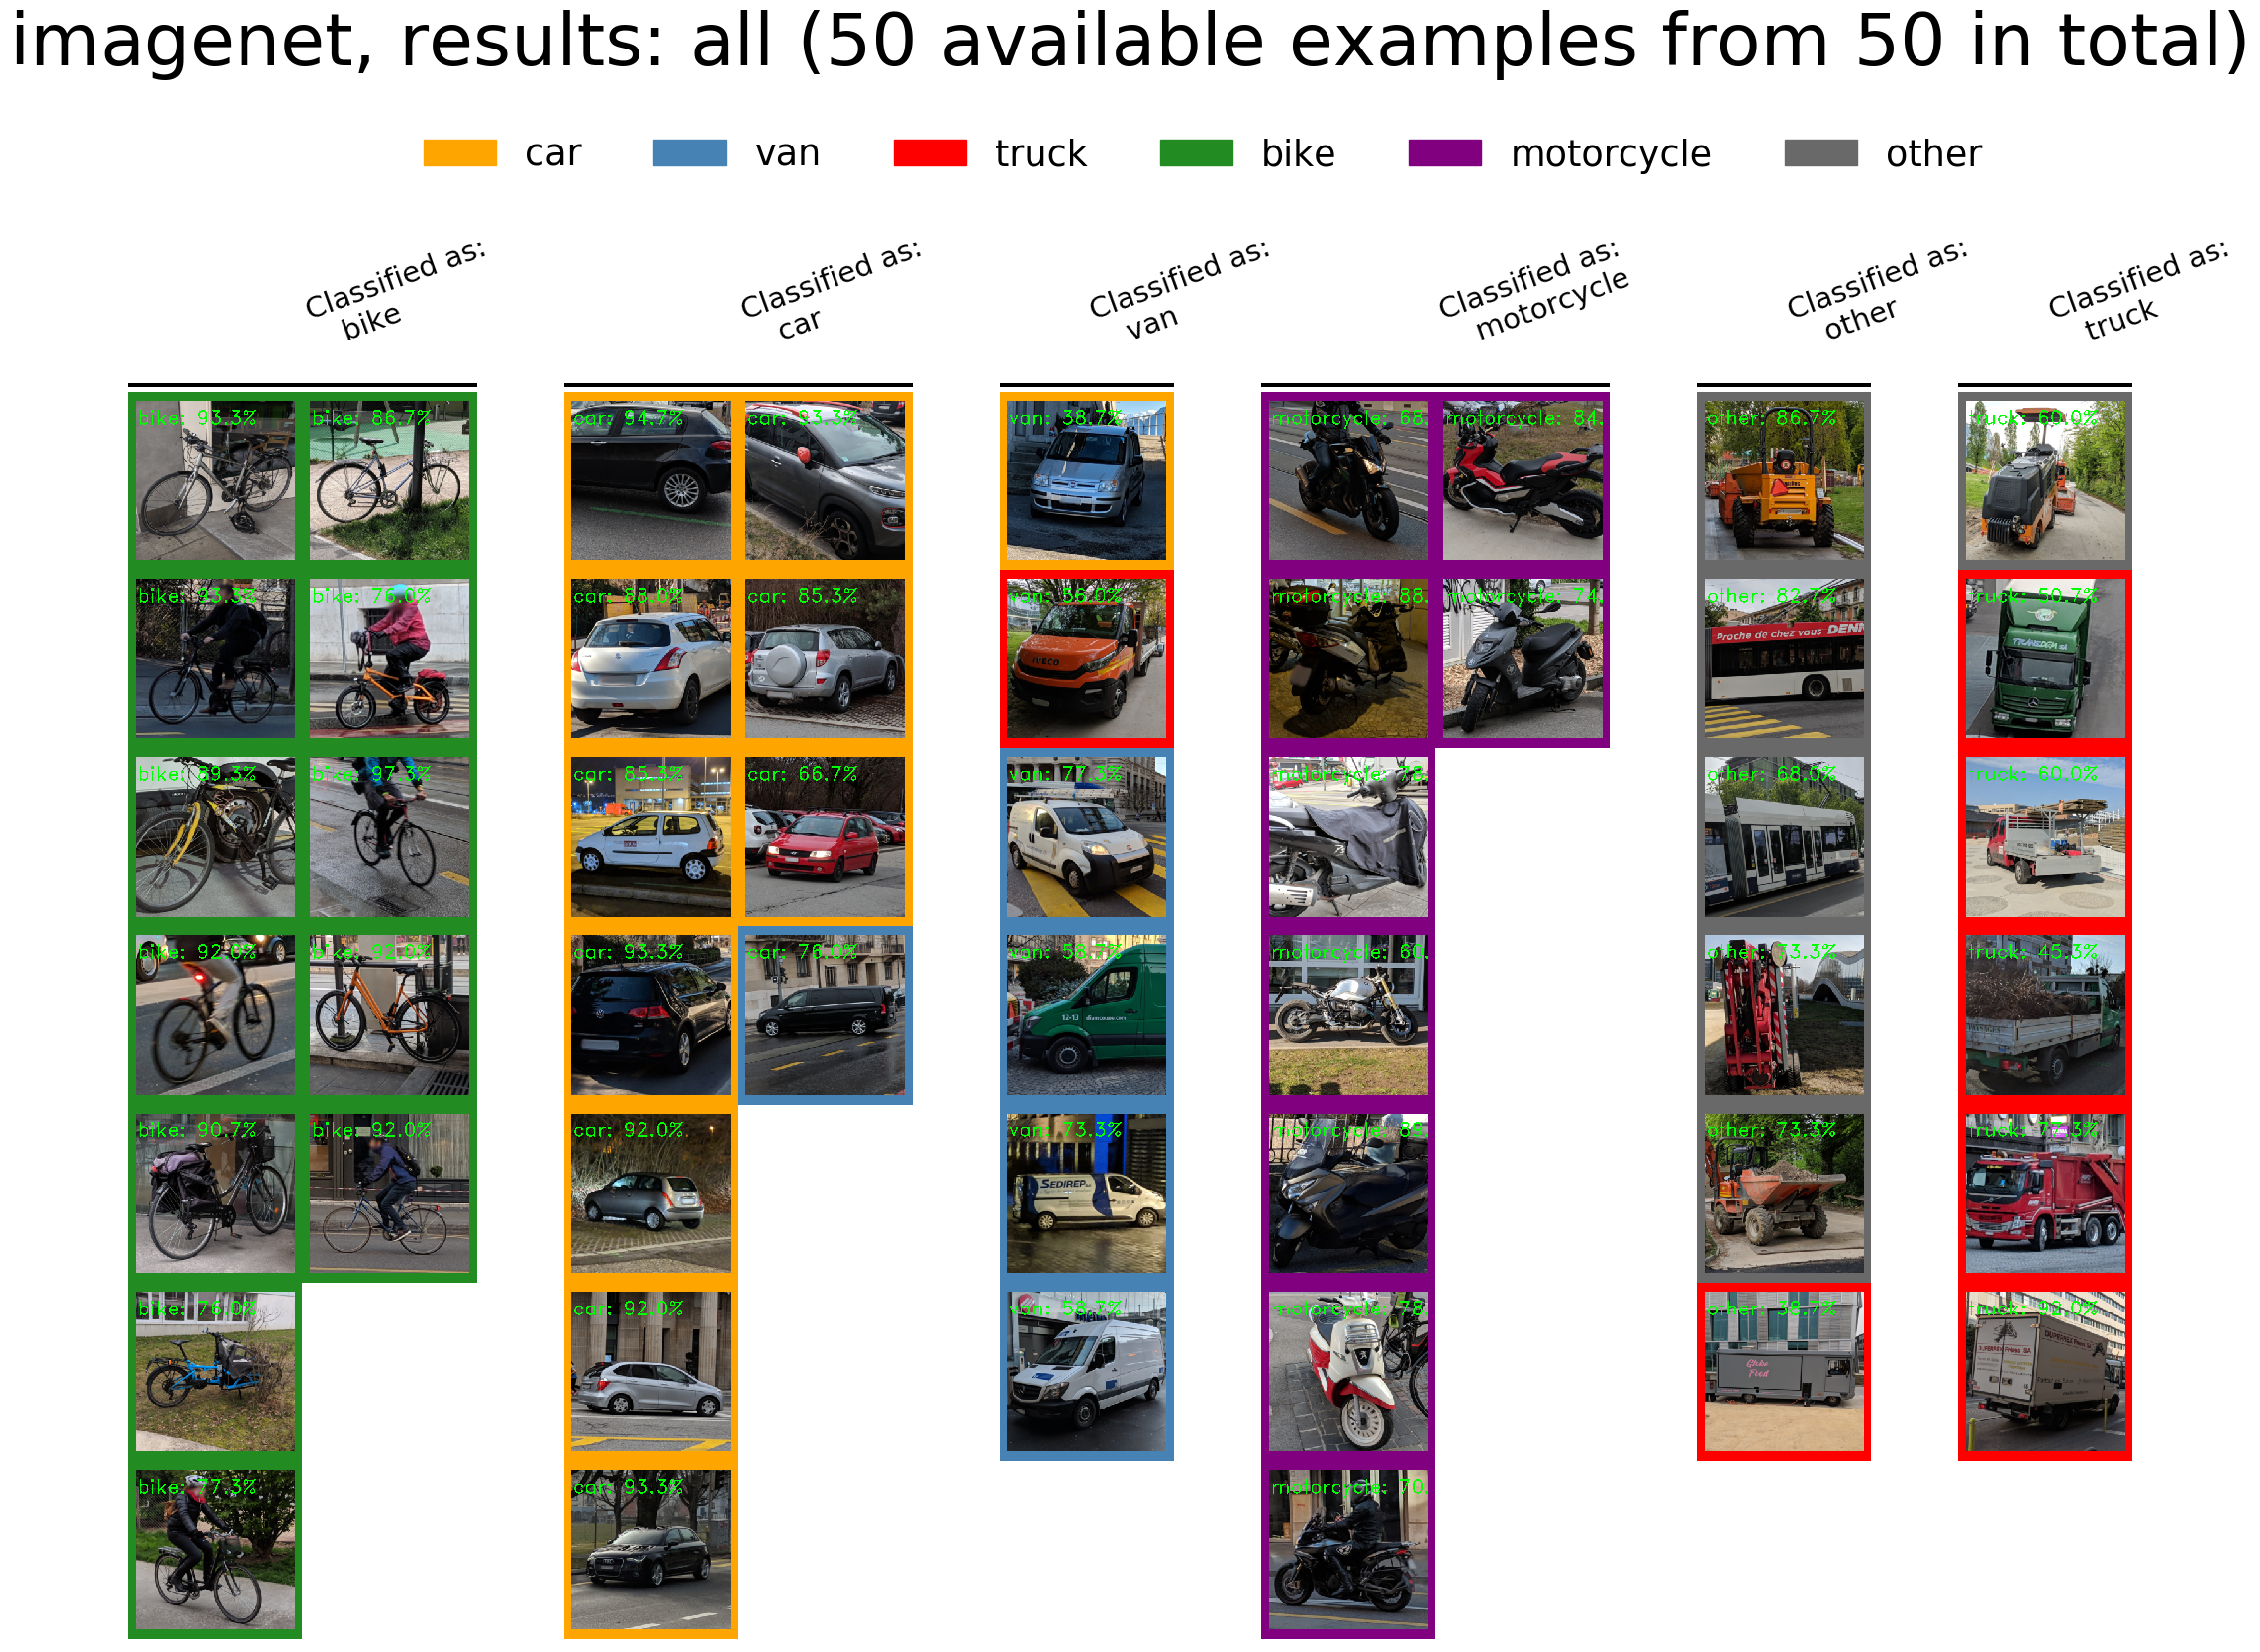

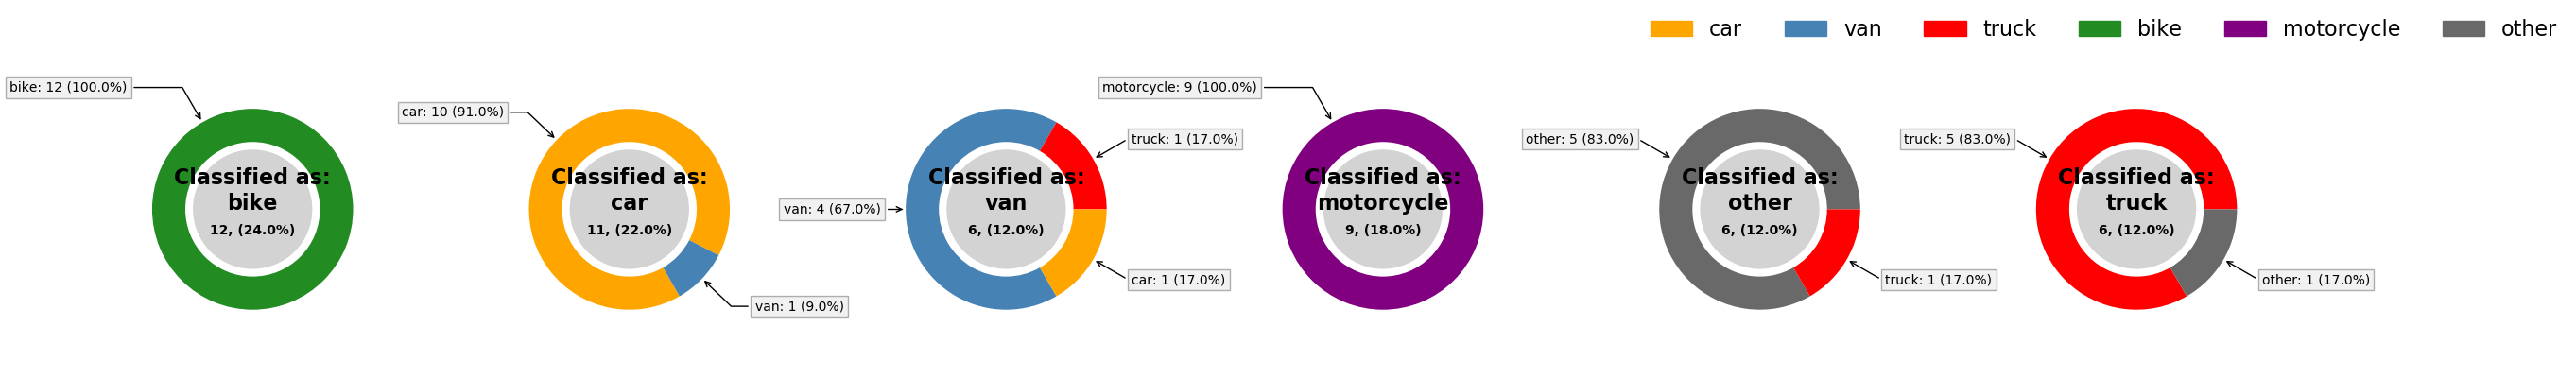

In [10]:
# select model_ID of the best performin model from the above table, 
model_ID = 226

# load model_predictions_dict
os.chdir(PATH_results)
with open(f"{task_name}__{module_names[0]}__{dataset_name}__model_predictions_dict.p", 'rb') as file: # wb - write binary,
    model_predictions_dict  = pickle.load(file) 
          
plot_examples_with_predictions_and_proba_gamma( 
    model_ID=model_ID,
    model_predictions_dict= model_predictions_dict, 
    module_name=module_names[0], 
    dataset_name=dataset_name,                              
    subset_name=["test"], # denotes test predicitons made for test_subset_names
    img_batch_subset_names=test_subset_names, 
    path_to_raw_img_batch=PATH_raw,
    class_colors=class_colors,
    make_plot_with_img_examples=True, # use False, to have only pie charts with classyfication summary                                         
    max_img_per_col=7,
    plot_classyfication_summary=True
)

# APPENDIX. Load Example tree created with best performing model 
#### (it is one of many trees used bythat model)

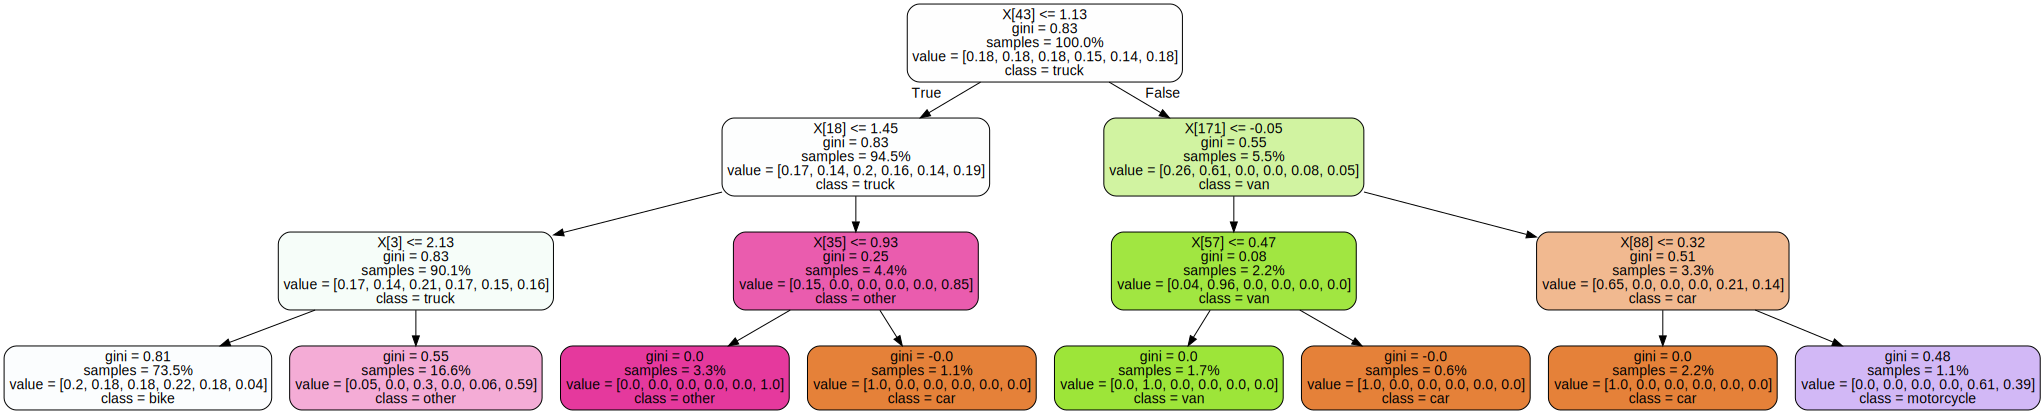

In [12]:
# Show example tree
"""in order to have relatively small tree to display, I will use the best possible model with max depth == 3"""

# find best perfomrming model with max_deph==3
summary_df_max_depth_3 = summary_df.loc[summary_df.max_depth==3,:]
summary_df_max_depth_3_sorted = summary_df_max_depth_3.sort_values("model_acc_test", ascending=False)

# extract model parameters from summary table
best_model_model_ID = summary_df_max_depth_3_sorted.model_ID.iloc[0]
best_model_module_name = summary_df_max_depth_3_sorted.module.iloc[0]

# load saved trees caulated for each model,
os.chdir(PATH_results)
with open(f"{task_name}__{best_model_module_name}__{dataset_name}__dot_data_dict.p", 'rb') as file:  
    dot_data_dict = pickle.load(file)

# select model ID from the table above, 
graphviz.Source(dot_data_dict[best_model_model_ID]['dot_data']) #  CAUTION - this must be the last function in a cell !!!! 